# Bayesian Treatment and Response - Part II

In the initial notebook, we got the basic ideas going. Now, we make the problem a little more complex by adding a dichotomous treatment. This introduces some nuances into the problem that highlight some of the points of interest of a Bayesian approach. So, let's discuss the new model. 

## Treatment and Control Groups

WE now discuss a case in which there are a treatment and control group. We might think about this more generally as an endogenous switching regression, where agents select into different groups in part based on things we observe about them. Let's take treatment to be a dichotomous variable $z = \{0,1\}$, and we observe $z=1$ if some underlying latent variable $z^*$, is greater than zero, and $z=0$ otherwise. 

As a practical matter, we think of the selection-into-treatment equation as a Probit model, where:
$$
z^* = \eta W + u_c + \epsilon_z
$$
And 
$$ \begin{array}{ccc}
z = 1 & \textrm{if} & z^* = \eta W + u_c + e_z > 0 \\
z = 0 & \textrm{otherwise} &
\end{array}
$$

Outcome equations differ based on whether or not the individual is treated. If $z=1$, the following equation explains the outcome $y$:
$$
y_1 = X\beta_1 + \pi_{1r}u_r + \pi_{1c}u_c + e_1
$$
and if $z=0$,
$$
y_0 = X\beta_0 + \pi_{0r}u_r + \pi_{0c}u_c + e_0
$$

The terms $u_r$, and $u_c$ are once again specified as standard normal random variables. These, once again, are unobserved latent factors that we shall consider parameters like all the other parameters in the model. Note that I have assumed there are two such factors. One, $u_c$ (the c is a mnemonic for "common"), induces correlation across outcomes and treatment. The other, $u_r$, appears only in the outcome equations (the r is a mnemonic for "result"), and induces correlation across outcomes. 

### P oint of interest

In observational data, we never actually observe both outcomes for a given individual. I.e., we don't see what happens to a patient if he or she both takes and does not take a medication. But a Bayesian method allows us to consider this as well - the idea is to treat the unobserved outcome as yet another latent variable that is estimated/simulated along with everything else. 

To see how model parameters capture correlation in outcomes, note that the (unconditional) variance matrix of the outcomes and treatment is:

$$
\Sigma = \left[
\begin{array}{ccc}
\sigma_1^2 + \pi_{1r}^2+\pi_{1c}^2 & \pi_{1r}\pi_{0r}+\pi_{1c}\pi_{0c} & \pi_{1c} \\
                                   & \sigma_0^2 + \pi_{0r}^2+\pi_{0c}^2 & \pi_{0c} \\
                                   &      &  \sigma_z^2 + 1 
\end{array}
\right]
$$
Usually, we have to also assume that $\sigma_z=1$ because of the indeterminacy of the scale parameter in a probit model. 






So, given all of this, let's write the likelihood of everything in the model as follows:

$$
L = \frac{e^{-\frac{(y_1-X\beta_1-\pi_{r1}u_r-\pi_{c1}u_c)^2}{2\sigma_1^2}}}{\sqrt{2\pi \sigma_1^2}} \times \frac{e^{-\frac{(y_0-X\beta_0-\pi_{r0}u_r-\pi_{c0}u_c)^2}{2\sigma_0^2}}}{\sqrt{2\pi \sigma_0^2}} \times \\
\frac{e^{-\frac{(z_1-W\eta-u_c)^2}{2}}}{\sqrt{2\pi}} \times \textrm{Prior}
$$

As written, the likelihood above assumes that everything is known. Of course, many things in the problem are not, such as the unobserved outcome and also the actual value of the latent variable $z$. But, in a Bayesian analysis, we just draw these variables along with everything else. Let's consider another `Stata` implementation of this model, where we draw unobserved outcomes along with everything else. 

## Example application

As usual, we will work with a stock Stata example and use the `ipystata` interface. Here, we use the classic union data set and try to get a feel for the impact of union membership on wages. So, in this case, we have a dichotomous treatment variable with one instrument (in the south). 

To flesh out the research problem further, we might be worried that this instrument isn't all that great. 

We start by importing ipystata, and then reading in the data:

In [1]:
import ipystata

In [2]:
%%stata
clear all 
use http://www.stata-press.com/data/r13/union3
set more off
keep if union != . 
keep if tenure != .
describe 
set seed 5150


(National Longitudinal Survey.  Young Women 14-26 years of age in 1968)
(449 observations deleted)
(34 observations deleted)

Contains data from http://www.stata-press.com/data/r13/union3.dta
  obs:         1,210                          National Longitudinal Survey.
                                                Young Women 14-26 years of age
                                                in 1968
 vars:            24                          11 Mar 2013 09:47
 size:        55,660                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
idcode          int     %8.0g                 NLS ID
year            byte    %8.0g                 interview year
birth_yr        byte    %8.0g                 birth year
age             byte    %8.0g                 age 

Now, let's just fit some preliminary models and get a feel for the problem:

### Simple regression

In [3]:
%%stata
regress wage age grade smsa black tenure union


      Source |       SS           df       MS      Number of obs   =     1,210
-------------+----------------------------------   F(6, 1203)      =    103.36
       Model |  2163.49455         6  360.582425   Prob > F        =    0.0000
    Residual |  4196.70492     1,203  3.48853277   R-squared       =    0.3402
-------------+----------------------------------   Adj R-squared   =    0.3369
       Total |  6360.19947     1,209  5.26071089   Root MSE        =    1.8678

------------------------------------------------------------------------------
        wage |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         age |   .1475526   .0195242     7.56   0.000     .1092474    .1858578
       grade |   .4368545   .0294718    14.82   0.000     .3790327    .4946764
        smsa |   .9754817   .1252669     7.79   0.000     .7297159    1.221248
       black |  -.6183346      .1252    -4.94   0.

Treatment regression (with endogeneity) and a standard IV regression, which ignores the dichotomous nature of the treatment variable. 

In [4]:
%%stata
etregress wage age grade smsa black tenure, treat(union = south black tenure)
ivregress 2sls wage age grade smsa black tenure (union = south black tenure), first


Iteration 0:   log likelihood =  -3140.811  
Iteration 1:   log likelihood = -3053.6629  
Iteration 2:   log likelihood = -3051.5847  
Iteration 3:   log likelihood =  -3051.575  
Iteration 4:   log likelihood =  -3051.575  

Linear regression with endogenous treatment     Number of obs     =      1,210
Estimator: maximum likelihood                   Wald chi2(6)      =     681.89
Log likelihood =  -3051.575                     Prob > chi2       =     0.0000

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
wage         |
         age |   .1487409   .0193291     7.70   0.000     .1108566    .1866252
       grade |   .4205658   .0293577    14.33   0.000     .3630258    .4781058
        smsa |   .9117044   .1249041     7.30   0.000     .6668969    1.156512
       black |  -.7882471   .1367078    -5.77 

Now, let's read the data into `Mata`, and also get some initial values into `Mata` in anticipation of estimation routines. 

In [5]:
%%stata
mata:
    st_view(y=., ., "wage")
    st_view(tr=., ., "union")
    st_view(X=., ., "age grade smsa black tenure")
    st_view(W=., ., "south black tenure")
    X = X, J(rows(y), 1, 1)
    W = W, J(rows(y), 1, 1)
end

quietly reg wage age grade smsa black tenure if union == 1
mat binit1 = e(b)

quietly reg wage age grade smsa black tenure if union == 0
mat binit0 = e(b) 

quietly probit union south black tenure
mat einit = e(b)


mata: 
    b1 = st_matrix("binit1"), 0, 0
    b0 = st_matrix("binit0"), 0, 0
    e = st_matrix("einit")
    nb = cols(b1)
    ne = cols(e)
end


:     st_view(y=., ., "wage")

:     st_view(tr=., ., "union")

:     st_view(X=., ., "age grade smsa black tenure")

:     st_view(W=., ., "south black tenure")

:     X = X, J(rows(y), 1, 1)

:     W = W, J(rows(y), 1, 1)

--------------------------------------------------------------------------------
------------------------------------------------- mata (type end to exit) ------
:     b1 = st_matrix("binit1"), 0, 0

:     b0 = st_matrix("binit0"), 0, 0

:     e = st_matrix("einit")

:     nb = cols(b1)

:     ne = cols(e)


One further thing we need to do is make a more stable inverse-normal function. This is because if a normal probability winds up being either one or zero, the stock invnormal function will return a missing. We don't want this to stop estimation in its tracks. 

In [6]:
%%stata 
mata:
    real matrix invnormstab(X) {
        XHat = editvalue(X, 0, 1e-323)
        XHat = editvalue(XHat, 1, 1e-16 )
        return(XHat)
    }
    end


:     real matrix invnormstab(X) {
>         XHat = editvalue(X, 0, 1e-323)
>         XHat = editvalue(XHat, 1, 1e-16 )
>         return(XHat)
>     }

:     end


Now, we make some placeholders for parameters, also put some prior distributions into action. Here it goes:

In [7]:
%%stata
mata:
    b1Hold        = J(0, nb, .)
    b0Hold        = J(0, nb, .)
    eHold         = J(0, ne, .)
    sy1Hold       = J(0, 1, .)
    sy0Hold       = J(0, 1, .)
    uHold         = J(rows(y),0,.)


    Tb = I(nb)*100
    Te = I(ne)*100

    ur = rnormal(rows(y), 1, 0, 1)
    uc = rnormal(rows(y), 1, 0, 1)

    sy12 = 1
    sy02 = 1
    
    draws = 10000
end


:     b1Hold        = J(0, nb, .)

:     b0Hold        = J(0, nb, .)

:     eHold         = J(0, ne, .)

:     sy1Hold       = J(0, 1, .)

:     sy0Hold       = J(0, 1, .)

:     uHold         = J(rows(y),0,.)

:     Tb = I(nb)*100

:     Te = I(ne)*100

:     uc = rnormal(rows(y), 1, 0, 1)

:     sy02 = 1

:     
:     draws = 10000


In [8]:
%%stata
mata:
    for (d=1;d<=draws;d++) {

        Xu = (X, ur, uc)
        y0Hat = Xu*b0' :+ rnormal(rows(y) , 1, 0, 1):*sqrt(sy02)
        y1Hat = Xu*b1' :+ rnormal(rows(y) , 1, 0, 1):*sqrt(sy12)
        y1 = tr:*y :+ (1 :- tr):*y1Hat
        y0 = (1 :- tr):*y :+ tr:*y0Hat

        muz = W*e' :+ uc
        et  = invnormstab( normal(-muz) :+ (1 :- normal(-muz)):*runiform(rows(muz),1) )
        ent = invnormstab( normal(-muz):*runiform(rows(muz),1))
        z = muz :+ et:*tr :+ ent:*(1:-tr)
        meane = invsym(W'W + invsym(Te))*W'(z :- uc)
        vare  = invsym(W'W + invsym(Te))
        e = meane + cholesky(vare)*rnormal(cols(e),1,0,1)
        e = e'

        Xu = X, ur, uc
        mb1 = invsym(Xu'Xu + invsym(Tb))*Xu'y1
        mb0 = invsym(Xu'Xu + invsym(Tb))*Xu'y0
        vb1 = sy12*invsym(Xu'Xu + invsym(Tb))
        vb0 = sy02*invsym(Xu'Xu + invsym(Tb))
        chol1b = cholesky(vb1)
        chol0b = cholesky(vb0)
        b1 = mb1 + chol1b*rnormal(nb, 1, 0, 1)
        b1 = b1'
        b0 = mb0 + chol0b*rnormal(nb, 1, 0, 1)
        b0 = b0'

        shp = rows(y)/2
        scl = (y-Xu*b1')'(y-Xu*b1')/2
        scl = 1/scl
        sy12 = rgamma(1, 1, shp, scl)

        scl = (y-Xu*b0')'(y-Xu*b0')/2
        scl = 1/scl
        sy02 = rgamma(1, 1, shp, scl)

        b1Hold  =  b1Hold \ b1
        b0Hold  = b0Hold \ b0
        eHold   =  eHold \ e
        sy1Hold =  sy1Hold \ sy12
        sy0Hold =  sy0Hold \ sy02
        
        /* Draw latent vars */
        
        pi1r = b1[cols(b1) - 1]
        pi0r = b0[cols(b0) - 1]
        b1z = b1
        b0z = b0
        b1z[cols(b1) - 1] = 0
        b0z[cols(b0) - 1] = 0
        A = (pi1r^2/sy12 + pi0r^2/sy02 + 1)
        B = (y1 - Xu*b1z')*pi1r/sy12 + (y0 - Xu*b0z')*pi0r/sy02
        ur = B/A + rnormal(rows(y), 1 , 0, 1/A)

        pi1c = b1[cols(b1)]
        pi0c = b0[cols(b0)]
        b1z = b1
        b0z = b0
        b1z[cols(b1)] = 0
        b0z[cols(b0)] = 0
        A = (pi1c^2/sy12 + pi0c^2/sy02 + 2)
        B = (y1 - Xu*b1z')*pi1c/sy12 + (y0 - Xu*b0z')*pi0c/sy02 + (z - W*e' )
        uc = B/A + rnormal(rows(y), 1 , 0, 1/A)
    }  
end


:     for (d=1;d<=draws;d++) {
> 
>         Xu = (X, ur, uc)
>         y0Hat = Xu*b0' :+ rnormal(rows(y) , 1, 0, 1):*sqrt(sy02)
>         y1Hat = Xu*b1' :+ rnormal(rows(y) , 1, 0, 1):*sqrt(sy12)
>         y1 = tr:*y :+ (1 :- tr):*y1Hat
>         y0 = (1 :- tr):*y :+ tr:*y0Hat
> 
>         muz = W*e' :+ uc
>         et  = invnormstab( normal(-muz) :+ (1 :- normal(-muz)):*runiform(rows(
> muz),1) )
>         ent = invnormstab( normal(-muz):*runiform(rows(muz),1))
>         z = muz :+ et:*tr :+ ent:*(1:-tr)
>         meane = invsym(W'W + invsym(Te))*W'(z :- uc)
>         vare  = invsym(W'W + invsym(Te))
>         e = meane + cholesky(vare)*rnormal(cols(e),1,0,1)
>         e = e'
> 
>         Xu = X, ur, uc
>         mb1 = invsym(Xu'Xu + invsym(Tb))*Xu'y1
>         mb0 = invsym(Xu'Xu + invsym(Tb))*Xu'y0
>         vb1 = sy12*invsym(Xu'Xu + invsym(Tb))
>         vb0 = sy02*invsym(Xu'Xu + invsym(Tb))
>         chol1b = cholesky(vb1)
>         chol0b = cholesky(vb0)
>         b1 = mb1 + chol1

Now, we can take a look at the results. As usual, we just read these in and summarize them. 

In [12]:
%%stata 
preserve
clear
getmata (b1*) = b1Hold
getmata (b0*) = b0Hold
getmata (e*) = eHold
getmata sy1Hold
getmata sy0Hold

sum b1*
sum b0*
sum sy1Hold
sum sy0Hold


already preserved
r(621);

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
         b11 |     10,000    .0556255    .0738955   -.079713   .2285767
         b12 |     10,000    .3731535    .1124887   .0817961     .61062
         b13 |     10,000    .3034906    .3790581  -.5735484   1.389658
         b14 |     10,000   -.9669083    .5553637  -2.476367   .2401075
         b15 |     10,000    .0056944    .1711295  -.3573101   .4158455
-------------+---------------------------------------------------------
         b16 |     10,000   -.4200822    1.806337  -4.178572   5.080385
         b17 |     10,000   -5.721623    1.037817  -7.087616   .0067545
         b18 |     10,000    4.459617    .6247456   .0213472    5.39313

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
         b01 |     10,000    .09465

Let's also produce a few graphs so that we can see how these things evolve over time.


variable t already defined
r(110);
        time variable:  t, 1 to 10000
                delta:  1 unit
> eplace width(1000) height(800)


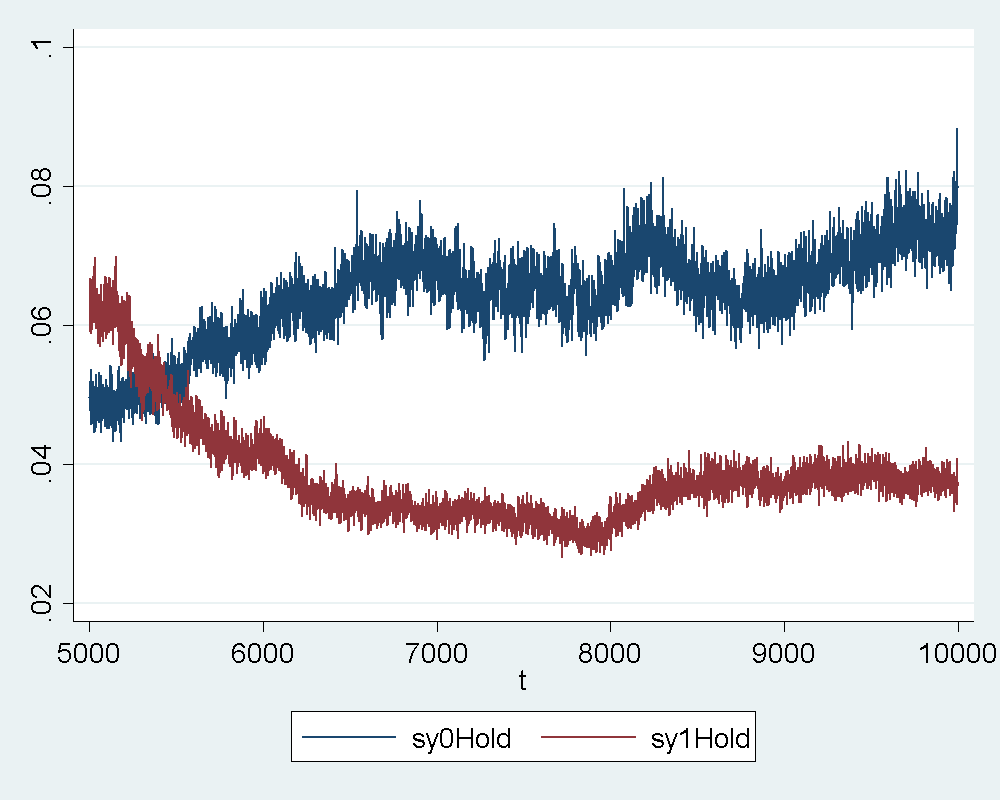

In [15]:
%%stata -gr
gen t = _n
tsset t
tsline sy0Hold sy1Hold if t>4999

In the next worksheet, we will try and see if we can get a dummy treatment, dummy response example going. But we should also measure the average treatment effect. 